## <center>Testing Latent Dirichlet Allocation (LDA) </center>
* [sklearn](#sklearn)
    * [How to Preprocess](#allocation)
    * [How to Evaluate](#evaluation)
    * [How to do Grid Search](#gridsearch)
    * [How to Visualize](#visualization)
* [gensim](#gensim)

In [1]:
import os
import tools
from glob import glob

def get_file_names(foldername):
    cwd = os.getcwd()
    files = glob(cwd + f"\\{foldername}\\*.txt")
    files = [f"{foldername}\\"+os.path.basename(x) for x in files]
    return files


def noun_extraction_almawadie(foldername):
    noun_list = tools.read_lines()
    files = get_file_names(foldername)
    files = [bytes(file, 'utf-8') for file in files]
    
    res = tools.doc_to_list(files, noun_list)
    return res

<a id='sklearn'></a>
# sklearn:
---
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [2]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = noun_extraction_almawadie("scripts_small")
docs = [" ".join([str(word) for word in doc]) for doc in data]

<a id='allocation'></a>
### <center> Steps Before The Allocation </center>
1. Create the Document-Word Matrix
2. Check the Sparsity
3. Build the Model

In [4]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                         # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(docs)

# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=4,            # Number of topics
                                      max_iter=1000,              # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

C:\Users\znowak\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsicity:  48.2429718875502 %


<a id='evaluation'></a>
### <center> Steps for Evalutation </center>
1. Run the Model
2. Analyze the Proportion
     * Higher log-likelihood
     * Lower Perplexity (is the inverse probability of the test set, normalized by the number of words. $$ \sqrt[\leftroot{-2}\uproot{2}N]{\frac{1}{P(w_1w_2w_3\ldots w_N)}} $$

In [5]:
# Fit
lda_output = lda_model.fit_transform(data_vectorized)

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

C:\Users\znowak\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -400937.18684658327
Perplexity:  784.7779138826438


<a id='gridsearch'></a>
### <center> Grid Search </center>
---
Automate the process of trying a bunch of different hyper parameters

In [6]:
n_topics = [4, 5, 10]
# Define Search Param
search_params = {'n_components': n_topics, 'learning_decay': [.1, .3, .5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 4}
Best Log Likelihood Score:  -93895.93699349095
Model Perplexity:  787.4324845381396


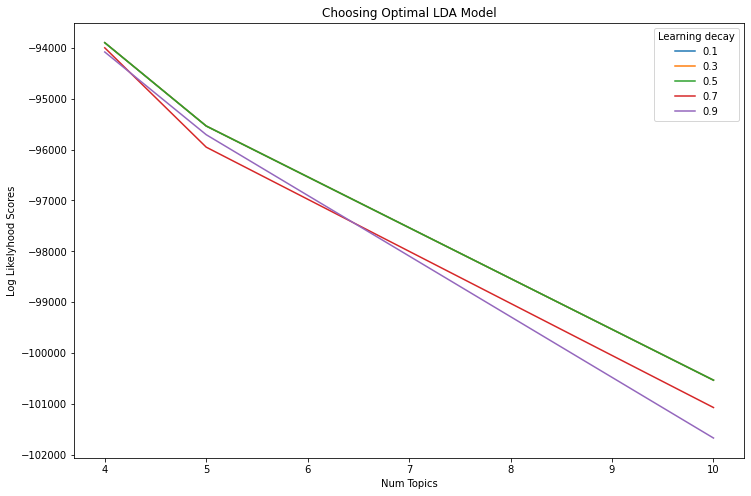

In [7]:
# Get Log Likelyhoods from Grid Search Output
cv_res = list(zip(model.cv_results_['params'], model.cv_results_['mean_test_score']))
log_likelyhoods_5 = [round(gscore[1]) for gscore in cv_res if gscore[0]['learning_decay']==0.1]
log_likelyhoods_7 = [round(gscore[1]) for gscore in cv_res if gscore[0]['learning_decay']==0.3]
log_likelyhoods_5 = [round(gscore[1]) for gscore in cv_res if gscore[0]['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore[1]) for gscore in cv_res if gscore[0]['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore[1]) for gscore in cv_res if gscore[0]['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.1')
plt.plot(n_topics, log_likelyhoods_5, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

<a id='visualization'></a>
## <center> Visualizations </center>

In [8]:
import pandas as pd
import numpy as np
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

If You Have a Few Documents You Want to Analyze Use This

In [9]:
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.000000,1.000000,0.000000,0.000000,1
Doc1,0.000000,1.000000,0.000000,0.000000,1
Doc2,0.000000,1.000000,0.000000,0.000000,1
Doc3,0.000000,0.000000,0.000000,1.000000,3
Doc4,0.610000,0.000000,0.000000,0.380000,0
Doc5,0.480000,0.000000,0.000000,0.520000,3
Doc6,0.830000,0.000000,0.000000,0.170000,0
Doc7,1.000000,0.000000,0.000000,0.000000,0
Doc8,0.000000,0.000000,1.000000,0.000000,2
Doc9,0.000000,0.000000,1.000000,0.000000,2


If You Have a Lot of Documents You Want to Analyze Use This <br>
P.S. What does the mds do?
Dimension reduction!
* pcoa:Principal Coordinate Analysis(aka Classical Multidimensional Scaling)

* mmds:Metric Multidimensional Scaling

* tsne:t-distributed Stochastic Neighbor Embedding

In [10]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\zacan\anaconda3\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\zacan\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      269.562408 -124.803398       1        1  33.457478
0        1.782994 -295.079681       2        1  28.526348
1      220.811432 -343.832123       3        1  23.905702
3       50.533993  -76.050934       4        1  14.110473, topic_info=         Term        Freq       Total Category  logprob  loglift
1040     luke  881.000000  881.000000  Default  30.0000  30.0000
942      kirk  693.000000  693.000000  Default  29.0000  29.0000
797       han  572.000000  572.000000  Default  28.0000  28.0000
434      data  348.000000  348.000000  Default  27.0000  27.0000
1550     ship  740.000000  740.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
248   captain   56.704678  447.181086   Topic4  -5.0085  -0.1069
503      door   52.194858  385.637312   Topic4  -5.0914  -0.0417
598      eyes   50.738029  384.225687   Topic4  -5.1197  -0.0663
1183     open   47.494415  278.852985   Topic4  -5.1858   0.1882
1130    moves   49.894675  412.605694   Topic4  -5.1365  -0.1543

[301 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
20        1  0.131753     advice
20        4  0.790518     advice
26        1  0.947709  agreement
26        4  0.067693  agreement
38        1  0.049166      alley
...     ...       ...        ...
1976      4  0.392762    working
1988      1  0.405223        yes
1988      2  0.272824        yes
1988      3  0.196593        yes
1988      4  0.128388        yes

[567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

<a id='gensim'></a>
# Gensim (generate similiar)

In [11]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

C:\Users\zacan\anaconda3\envs\nlp\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\zacan\anaconda3\envs\nlp\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
data_words = noun_extraction_almawadie("scripts_small")
data_words = [[word.decode("utf") for word in page]for page in data_words]

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"his" + 0.030*"peter" + 0.024*"liz" + 0.013*"as" + 0.010*"door" + '
  '0.009*"weiner" + 0.008*"power" + 0.008*"building" + 0.007*"web" + '
  '0.007*"harry"'),
 (1,
  '0.043*"his" + 0.035*"luke" + 0.033*"as" + 0.023*"han" + 0.011*"ship" + '
  '0.010*"rey" + 0.010*"vader" + 0.009*"finn" + 0.008*"star" + 0.008*"falcon"'),
 (2,
  '0.042*"as" + 0.036*"kirk" + 0.036*"his" + 0.014*"captain" + 0.012*"sir" + '
  '0.012*"ship" + 0.010*"enterprise" + 0.010*"mccoy" + 0.008*"data" + '
  '0.008*"decker"'),
 (3,
  '0.032*"his" + 0.027*"as" + 0.017*"ship" + 0.012*"data" + 0.010*"room" + '
  '0.009*"captain" + 0.007*"queen" + 0.007*"time" + 0.007*"little" + '
  '0.006*"control"'),
 (4,
  '0.052*"his" + 0.030*"as" + 0.021*"bruce" + 0.019*"vicki" + 0.014*"batman" + '
  '0.009*"face" + 0.009*"joker" + 0.007*"alfred" + 0.005*"car" + 0.005*"cops"')]


In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.340672920983109

Coherence Score:  nan


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.082528 -0.068092       1        1  31.176870
2      0.099263  0.064960       2        1  24.228268
4     -0.119758 -0.094749       3        1  20.412924
3      0.070956  0.004127       4        1  17.308327
0     -0.132989  0.093755       5        1   6.873611, topic_info=          Term        Freq       Total Category  logprob  loglift
4249      luke  856.000000  856.000000  Default  30.0000  30.0000
3398      kirk  687.000000  687.000000  Default  29.0000  29.0000
4235       han  555.000000  555.000000  Default  28.0000  28.0000
175      bruce  331.000000  331.000000  Default  27.0000  27.0000
1644     vicki  307.000000  307.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
362      crowd   18.881657   86.767280   Topic5  -5.6602   1.1524
773        ill   22.283880  190.529920   Topic5  -5.4945   0.5315
313   computer   20.582766  140.874786   Topic5  -5.5740   0.7541
936        may   19.732213  123.970356   Topic5  -5.6162   0.8397
1357      side   20.582766  308.175922   Topic5  -5.5740  -0.0287

[350 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
21        3  0.997759  alfred
23        1  0.231464      am
23        2  0.422422      am
23        3  0.017360      am
23        4  0.225678      am
...     ...       ...     ...
1726      2  0.206184     yes
1726      3  0.078350     yes
1726      4  0.222679     yes
1726      5  0.107216     yes
2927      5  0.905232    york

[631 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 1])